In [26]:
import torch
from src.models.components.resnet import ResNet, ResNet4

use_cuda = torch.cuda.is_available()

# load the checkpoint
if use_cuda:
    checkpoint = torch.load('checkpoints/cifar10_resnet_new.ckpt')
    checkpoint_mixup = torch.load('checkpoints/cifar10_resnet_mixup_new.ckpt')
else:
    checkpoint = torch.load('checkpoints/cifar10_resnet_new.ckpt', map_location=torch.device('cpu'))
    checkpoint_mixup = torch.load('checkpoints/cifar10_resnet_mixup_new.ckpt', map_location=torch.device('cpu'))


state_dict = checkpoint['state_dict']
prefix = 'net.'
n_clip = len(prefix)
adapted_dict = {k[n_clip:]: v for k, v in state_dict.items() if k.startswith(prefix)}

state_dict = checkpoint_mixup['state_dict']
prefix = 'net.'
n_clip = len(prefix)
adapted_dict_mixup = {k[n_clip:]: v for k, v in state_dict.items() if k.startswith(prefix)}

# get the model architecture
model = ResNet(layers=[2, 2, 2], num_classes=10)
model.load_state_dict(adapted_dict)

# get the model architecture
model_mixup = ResNet(layers=[2, 2, 2], num_classes=10)
model_mixup.load_state_dict(adapted_dict_mixup)

<All keys matched successfully>

In [27]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# load the dataset
dataset = datasets.CIFAR10(root='../data/', train=False, download=True, transform=transform)
_, data_test = random_split(
    dataset=dataset,
    lengths=[5_000, 5_000],
    generator=torch.Generator().manual_seed(42),
)

Files already downloaded and verified


## Embeddings

In [28]:
import numpy as np
model.eval()
model_mixup.eval()

features,  features_mixup = [], []
labels = []
with torch.no_grad():
    for data, label in data_test:
        data = data.unsqueeze(0)
        feature = model.features(data)
        features.append(feature.cpu().numpy()[0])

        feature_mixup = model_mixup.features(data)
        features_mixup.append(feature_mixup.cpu().numpy()[0])
        labels.append(label)

features = np.array(features)
features_mixup = np.array(features_mixup)
labels = np.array(labels)

## TSNE

/Users/piotrhelm/Desktop/IN/masterT/master-thesis/python/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/piotrhelm/Desktop/IN/masterT/master-thesis/python/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



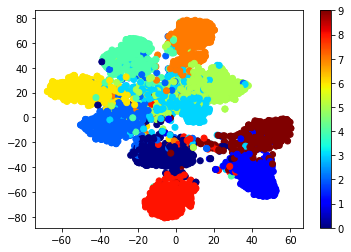

In [37]:
from sklearn.manifold import TSNE

# apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features)

import matplotlib.pyplot as plt

# create a scatter plot of the t-SNE results
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.savefig("tsne-2d-cifar10.png")

/Users/piotrhelm/Desktop/IN/masterT/master-thesis/python/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/piotrhelm/Desktop/IN/masterT/master-thesis/python/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



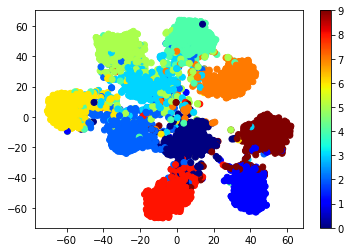

In [38]:
from sklearn.manifold import TSNE

# apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features_mixup)

import matplotlib.pyplot as plt

# create a scatter plot of the t-SNE results
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.savefig("tsne-2d-cifar10-mixup.png")

In [31]:
import plotly.graph_objs as go
from sklearn.manifold import TSNE

# Generate t-SNE embeddings
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000)
embeddings_3d = tsne.fit_transform(features)

# Create a 3D scatter plot
fig = go.Figure(data=go.Scatter3d(
    x=embeddings_3d[:,0],
    y=embeddings_3d[:,1],
    z=embeddings_3d[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=labels,  # y contains the labels of each data point
        colorscale='Viridis',
        opacity=0.8
    )
))

# Set axis labels and plot title
fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    title='3D t-SNE Cifar10 Latent Space'
)

# Show the plot
fig.show()

/Users/piotrhelm/Desktop/IN/masterT/master-thesis/python/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/piotrhelm/Desktop/IN/masterT/master-thesis/python/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [32]:
fig.write_html("cifar10-tsne.html")

In [210]:
import plotly.graph_objs as go
from sklearn.manifold import TSNE

# Generate t-SNE embeddings
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000)
embeddings_3d_mixup = tsne.fit_transform(features_mixup)

# Create a 3D scatter plot
fig = go.Figure(data=go.Scatter3d(
    x=embeddings_3d[:,0],
    y=embeddings_3d[:,1],
    z=embeddings_3d[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=labels,  # y contains the labels of each data point
        colorscale='Viridis',
        opacity=0.8
    )
))

# Set axis labels and plot title
fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    title='3D t-SNE Cifar10 Mixup Latent Space'
)

# Show the plot
fig.show()

/Users/piotrhelm/Desktop/IN/masterT/master-thesis/python/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/piotrhelm/Desktop/IN/masterT/master-thesis/python/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [34]:
fig.write_html("cifar10-mixup-tsne.html")

## Quantitative

In [77]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Compute the Jaccard similarity between top-k neighbors in the source and target spaces
k = 10
jaccard_similarity = []
for i in range(features.shape[0]):
    source_neighbors = cosine_similarity(features[i].reshape(1, -1), features)[0].argsort()[-k:]
    target_neighbors = cosine_similarity(features[i].reshape(1, -1), features_mixup)[0].argsort()[-k:]
    jaccard_similarity.append(len(set(source_neighbors).intersection(target_neighbors)) / len(set(source_neighbors).union(target_neighbors)))

# Compute the mean reciprocal rank for each embedded word in the source space
reciprocal_rank = []
for i in range(features.shape[0]):
    distances = cosine_similarity(features[i].reshape(1, -1), features)[0]
    idx = distances.argsort()[-k:]
    reciprocal_rank.append(np.mean(distances[idx[:k-1]]))

# Compute the Jaccard similarity between top-k neighbors in the target and source spaces
k = 10
jaccard_similarity_reversed = []
for i in range(features_mixup.shape[0]):
    source_neighbors = cosine_similarity(features_mixup[i].reshape(1, -1), features_mixup)[0].argsort()[-k:]
    target_neighbors = cosine_similarity(features_mixup[i].reshape(1, -1), features)[0].argsort()[-k:]
    jaccard_similarity_reversed.append(len(set(source_neighbors).intersection(target_neighbors)) / len(set(source_neighbors).union(target_neighbors)))

# Compute the mean reciprocal rank for each embedded word in the source space
reciprocal_rank_reversed = []
for i in range(features_mixup.shape[0]):
    distances = cosine_similarity(features_mixup[i].reshape(1, -1), features_mixup)[0]
    idx = distances.argsort()[-k:]
    reciprocal_rank_reversed.append(np.mean(distances[idx[:k-1]]))

In [177]:
stats = [[]]*10
stats_mixup = [[]]*10

In [178]:
for feature, feature_mixup, label in zip(features, features_mixup, labels):
    stats[label].append(list(feature))
    stats_mixup[label].append(list(feature_mixup))

In [174]:
centers = []
centers_mixup = []

In [183]:
for s1, s2 in zip(stats, stats_mixup):
    centers.append(np.mean(s1, axis=0))
    centers_mixup.append(np.mean(s2, axis=0))

In [212]:
from sklearn.cluster import KMeans

# create KMeans object with n_clusters=1
kmeans = KMeans(n_clusters=10)
kmeans_mixup = KMeans(n_clusters=10)

# fit KMeans object to the data
kmeans.fit(embeddings_3d)
kmeans_mixup.fit(embeddings_3d_mixup)

KMeans(n_clusters=10)

In [213]:
centers = kmeans.cluster_centers_
centers_mixup = kmeans_mixup.cluster_centers_

In [214]:
distances = np.zeros((len(centers), len(centers)))

# calculate pairwise distances between all vectors
for i in range(len(centers)):
    for j in range(i+1, len(centers)):
        distances[i, j] = np.linalg.norm(np.array(centers[i]) - np.array(centers[j]))
        distances[j, i] = distances[i, j]

# calculate the mean of all distances
mean_distance = np.mean(distances.ravel())

In [215]:
mean_distance

20.28562047958374

In [216]:
distances_mixup = np.zeros((len(centers_mixup), len(centers_mixup)))

# calculate pairwise distances between all vectors
for i in range(len(centers_mixup)):
    for j in range(i+1, len(centers_mixup)):
        distances_mixup[i, j] = np.linalg.norm(np.array(centers_mixup[i]) - np.array(centers_mixup[j]))
        distances_mixup[j, i] = distances_mixup[i, j]

# calculate the mean of all distances
mean_distance_mixup = np.mean(distances_mixup.ravel())

In [217]:
mean_distance_mixup

20.0909494972229

In [208]:
distances_mixup

array([[0.        , 2.34414387, 3.00691628, 2.78048062, 2.53710341,
        3.18609095, 3.02637076, 2.64390111, 2.6451695 , 2.50234389],
       [2.34414387, 0.        , 3.11451769, 2.40388656, 2.65243268,
        3.27431798, 3.1096983 , 2.47068381, 2.43142772, 1.84285319],
       [3.00691628, 3.11451769, 0.        , 3.33737493, 2.73444319,
        2.87762523, 3.02929163, 3.25868654, 3.19171166, 3.12524557],
       [2.78048062, 2.40388656, 3.33737493, 0.        , 2.85243893,
        3.46085215, 3.16697931, 2.54215336, 2.40506911, 2.39761281],
       [2.53710341, 2.65243268, 2.73444319, 2.85243893, 0.        ,
        2.89277554, 2.62480617, 2.65488148, 2.34021592, 2.50707078],
       [3.18609095, 3.27431798, 2.87762523, 3.46085215, 2.89277554,
        0.        , 3.18309712, 3.47136545, 3.31547379, 3.33101821],
       [3.02637076, 3.1096983 , 3.02929163, 3.16697931, 2.62480617,
        3.18309712, 0.        , 3.22302556, 3.09145999, 3.19622636],
       [2.64390111, 2.47068381, 3.2586865

In [209]:
distances

array([[0.        , 6.83607674, 6.79686928, 5.99081993, 5.61407089,
        4.87481594, 6.57790852, 6.82327747, 5.55965805, 6.74052238],
       [6.83607674, 0.        , 5.01315355, 2.6993053 , 6.26074553,
        7.02658558, 4.90925455, 4.30518866, 5.21441126, 4.4336915 ],
       [6.79686928, 5.01315355, 0.        , 3.82058835, 6.02641058,
        6.6479249 , 6.06369209, 4.22353554, 5.40976143, 4.61367655],
       [5.99081993, 2.6993053 , 3.82058835, 0.        , 5.12464809,
        6.18822241, 4.44904041, 3.18306518, 4.08118486, 3.42606997],
       [5.61407089, 6.26074553, 6.02641058, 5.12464809, 0.        ,
        5.81846237, 6.17084694, 5.58654594, 4.29947996, 5.69392872],
       [4.87481594, 7.02658558, 6.6479249 , 6.18822241, 5.81846237,
        0.        , 6.89187288, 6.81445169, 5.80441427, 6.99799013],
       [6.57790852, 4.90925455, 6.06369209, 4.44904041, 6.17084694,
        6.89187288, 0.        , 5.30845022, 5.09690952, 4.34583426],
       [6.82327747, 4.30518866, 4.2235355

In [211]:
embeddings_3d_mixup

array([[ -0.63736385,  11.87075   ,  -0.10246778],
       [  9.152028  ,  -4.4344926 , -14.683126  ],
       [ -1.9823859 ,  10.177612  ,  -1.1456969 ],
       ...,
       [ -5.0160556 ,  -2.5510466 ,  -6.3814597 ],
       [  1.044888  ,  16.732315  ,   5.6787486 ],
       [ 10.393228  ,   4.886002  ,   9.298517  ]], dtype=float32)